In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# dataset
from keras.datasets import fashion_mnist

In [8]:
# loading the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# spliting data for validation
x_val = x_train[54000:]
y_val = y_train[54000:]
# print(x_val)
# print(y_val)
# spliting data for training
x_train = x_train[:54000]
y_train = y_train[:54000]
# print(x_train)
# print(y_train)

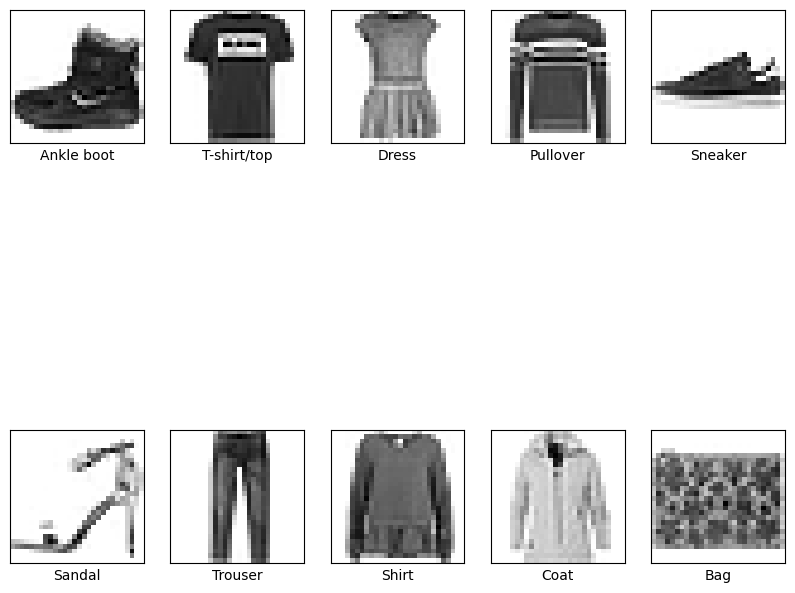

In [3]:
# labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
image = []
label = []
for i in range(54000):
  if len(label) >= 10:
    break;
  if class_names[y_train[i]] not in label:
      image.append(x_train[i])
      label.append(class_names[y_train[i]])

#the dimensions of the plot grid
plt.figure(figsize=(10,10))

for i in range(len(image)):
  plt.subplot(2, 5, i+1)  #plotting in a 2x5 grid
  plt.xticks([])  #remove x-ticks
  plt.yticks([])  #remove y-ticks
  plt.grid(False)  #no grid
  plt.imshow(image[i], cmap=plt.cm.binary)  #plotting the image in binary colormap
  plt.xlabel(label[i])  #x-axis label
plt.show()

In [4]:
# vectorise the data
x_train = x_train.reshape(x_train.shape[0], 784)
# print(x_train.shape)
x_val  = x_val.reshape(x_val.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val  = x_val / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

print(y_train[1023])
# one-hot encoding to the datasets
y_train_encode = one_hot_enc(y_train)
y_val_encode = one_hot_enc(y_val)
y_test_encode = one_hot_enc(y_test)

print(y_train_encode[1023])  # for verifying
print(y_train_encode.shape) #verifying

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(54000, 10)


In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x <= 0, 0, 1)

def cross_entropy(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m + regpara / 2 * sum_norm
    return loss

activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu
}

activation_derivatives = {
    "sigmoid": sigmoid_deriv,
    "relu": relu_deriv
}


In [6]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)

    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases


    def forward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat

    def backward(self, h, a, y, y_hat):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad

    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    def vanilla_gd(self, grads, eta):
        # i = 0 to L-1; here len(self.weights) = L (as weights = [W1,W2,W3,...], list of weights W1,W2,W3,....)
        for i in range(len(self.weights)):
            self.weights[i] -= eta * grads["dW" + str(i + 1)]   #updating W1,W2,W3 by grad_descent rule
            self.biases[i] -= eta * grads["db" + str(i + 1)]    #updating b1,b2,b3 by grad_descent rule

    def train_sgd(self, X_train, Y_train, eta=0.1, max_epochs=1000, batch_size=1, regpara=0.00):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.forward(X_batch)

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat)

                # Update weights and biases with SGD
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)] + regpara * self.weights[i-1])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")



    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization when we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.forward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy



In [7]:
layer_sizes = [784, 128, 64, 10]
model = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")
model.train_sgd(x_train, y_train_encode, eta=0.1, max_epochs=6, batch_size=1, regpara=0)

End of Epoch 0, Loss: 0.4297891545004381, Accuracy: 0.8414259259259259
End of Epoch 1, Loss: 0.3977361657065824, Accuracy: 0.8547962962962963
End of Epoch 2, Loss: 0.3698730204740379, Accuracy: 0.8642407407407408
End of Epoch 3, Loss: 0.35618316707093384, Accuracy: 0.8685925925925926
End of Epoch 4, Loss: 0.3399572275588841, Accuracy: 0.8728703703703704
End of Epoch 5, Loss: 0.35769491780755075, Accuracy: 0.8677222222222222
